**<h1>IMPORT LIBRARIES</h1>**

In [1]:
import os
import re
import pickle
import shap
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import ndcg_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from scipy.optimize import minimize

**<h1>READ DATASET</h1>**

In [ ]:
data = pd.read_csv('./resetted_index_cleaned_polarity_roberta.csv', index_col=0)
data

In [ ]:
pos = data[data['sentiment'] == 'positive'].head(312564)
neu = data[data['sentiment'] == 'neutral'].head(312564)
neg = data[data['sentiment'] == 'negative'].head(312564)
df = pd.concat([pos, neu, neg], ignore_index=True)

In [ ]:
df['sentiment'] = df['sentiment'].replace({'positive': 0, 'negative': 1, 'neutral': 2})
df.head()

**<h1>SPLIT DATASET</h1>**

In [ ]:
X = df['cleaned_review'].tolist()
for index, value in enumerate(X):
    if isinstance(value, float):
        X[index] = str(value)

In [ ]:
y = to_categorical(df['sentiment'])
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**<h1>TOKENIZATION</h1>**

In [2]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
shape = 96
batch_size = 64

In [ ]:
train_encodings = tokenizer(X_train, padding='max_length', truncation=True, max_length=shape, return_tensors='tf')

In [ ]:
test_encodings = tokenizer(X_test, padding='max_length', truncation=True, max_length=shape, return_tensors='tf')

## **SAVE TOKENIZATION**

In [4]:
save_path_train = './fix/train_encodings/'
save_path_test = './fix/test_encodings/'
save_path_y_train = './fix/y_train/y_train.tfrecord'
save_path_y_test = './fix/y_test/y_test.tfrecord'

In [ ]:
for key, value in train_encodings.items():
    tf.io.write_file(f"{save_path_train}/{key}.tfrecord", tf.io.serialize_tensor(value))

In [ ]:
for key, value in test_encodings.items():
    tf.io.write_file(f"{save_path_test}/{key}.tfrecord", tf.io.serialize_tensor(value))

In [ ]:
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [ ]:
serialized_tensor_train = tf.io.serialize_tensor(y_train_tensor)
serialized_tensor_test = tf.io.serialize_tensor(y_test_tensor)

In [ ]:
os.makedirs(os.path.dirname(save_path_y_train), exist_ok=True)
os.makedirs(os.path.dirname(save_path_y_test), exist_ok=True)

In [ ]:
tf.io.write_file(save_path_y_train, serialized_tensor_train)
tf.io.write_file(save_path_y_test, serialized_tensor_test)

## **LOAD TOKENIZATION**

In [5]:
serialized_tensor_train = tf.io.read_file(save_path_y_train)
serialized_tensor_test = tf.io.read_file(save_path_y_test)

In [6]:
loaded_tensor_train = tf.io.parse_tensor(serialized_tensor_train, out_type=tf.float32)
loaded_tensor_test = tf.io.parse_tensor(serialized_tensor_test, out_type=tf.float32)

In [7]:
loaded_y_train = loaded_tensor_train.numpy()
loaded_y_test = loaded_tensor_test.numpy()

In [8]:
loaded_train_encodings = {}
for key in ['input_ids', 'attention_mask', 'token_type_ids']:
    tensor = tf.io.read_file(f"{save_path_train}/{key}.tfrecord")
    loaded_train_encodings[key] = tf.io.parse_tensor(tensor, out_type=tf.int32)

In [9]:
loaded_test_encodings = {}
for key in ['input_ids', 'attention_mask', 'token_type_ids']:
    tensor = tf.io.read_file(f"{save_path_test}/{key}.tfrecord")
    loaded_test_encodings[key] = tf.io.parse_tensor(tensor, out_type=tf.int32)

**<h1>CONVERT TO TENSORFLOW DATASET</h1>**

In [10]:
def create_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
            'token_type_ids': encodings['token_type_ids']
        },
        tf.constant(labels)
    )).batch(batch_size, drop_remainder=True)

In [ ]:
train_tf_dataset = create_tf_dataset(train_encodings, y_train)
test_tf_dataset = create_tf_dataset(test_encodings, y_test)

In [11]:
train_tf_dataset = create_tf_dataset(loaded_train_encodings, loaded_y_train)
test_tf_dataset = create_tf_dataset(loaded_test_encodings, loaded_y_test)

**<h1>CNN MODEL</h1>**

In [ ]:
#bert_model.bert.pooler.trainable = False
#bert_model.classifier.trainable = False

In [12]:
input_ids = Input(shape=(shape,), dtype=tf.int32, name='input_ids')
token_type_ids = Input(shape=(shape,), dtype=tf.int32, name='token_type_ids')
attention_mask = Input(shape=(shape,), dtype=tf.int32, name='attention_mask')

In [13]:
bert_outputs = bert_model([input_ids, token_type_ids, attention_mask], output_hidden_states=True)
hidden_states = bert_outputs.hidden_states[-1]
logits = bert_outputs.logits

In [14]:
conv1d_layer = Conv1D(64, 8, activation='relu', kernel_regularizer=regularizers.l2(0.025))(hidden_states) #just recently added regularization
maxpooling1d_layer = MaxPooling1D(2)(conv1d_layer)
dropout_layer_1 = Dropout(0.45)(maxpooling1d_layer)

conv1d_layer_2 = Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.025))(dropout_layer_1) #just recently added regularization
maxpooling1d_layer_2 = MaxPooling1D(2)(conv1d_layer_2)
dropout_layer_2 = Dropout(0.45)(maxpooling1d_layer_2)

conv1d_layer_3 = Conv1D(256, 3, activation='relu', kernel_regularizer=regularizers.l2(0.025))(dropout_layer_2) #just recently added regularization
globalmaxpooling1d_layer = GlobalMaxPooling1D()(conv1d_layer_3)

combined_features = tf.concat([logits, globalmaxpooling1d_layer], axis=-1)

dense_layer = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.025))(combined_features)
output_layer = Dense(3, activation='softmax')(dense_layer)

**<h1>TRAIN MODEL</h1>**

In [15]:
combined_model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=output_layer)
combined_model.compile(optimizer=Adam(learning_rate=3e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
checkpoint = ModelCheckpoint('./fix/bert_cnn_best_model_batch_testing.keras', save_best_only=True, monitor='val_loss', mode='min')

In [17]:
history = combined_model.fit(train_tf_dataset, epochs=50, validation_data=(test_tf_dataset), callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/50
10256/10256 [==============================] - 6962s 678ms/step - loss: 10.3727 - accuracy: 0.7488 - val_loss: 7.9237 - val_accuracy: 0.7910 - lr: 3.0000e-06
Epoch 2/50
10256/10256 [==============================] - 6875s 670ms/step - loss: 5.6836 - accuracy: 0.8333 - val_loss: 4.0274 - val_accuracy: 0.8235 - lr: 3.0000e-06
Epoch 3/50
10256/10256 [==============================] - 6875s 670ms/step - loss: 2.7796 - accuracy: 0.8569 - val_loss: 1.9538 - val_accuracy: 0.8499 - lr: 3.0000e-06
Epoch 4/50
10256/10256 [==============================] - 6875s 670ms/step - loss: 1.3643 - accuracy: 0.8745 - val_loss: 1.0182 - val_accuracy: 0.8584 - lr: 3.0000e-06
Epoch 5/50
10256/10256 [==============================] - 6873s 670ms/step - loss: 0.7403 - accuracy: 0.8885 - val_loss: 0.6350 - val_accuracy: 0.8637 - lr: 3.0000e-06
Epoch 6/50
10256/10256 [==============================] - 6866s 669ms/step - loss: 0.4661 - accuracy: 0.9007 - val_loss: 0.4751 - val_accuracy: 0.8705 - lr: 3.

**<h1>HISTORY LOG</h1>**

In [18]:
with open('./fix/training_history_bert_cnn_best_model_batch_testing.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [19]:
with open('./fix/training_history_bert_cnn_best_model_batch_testing.pkl', 'rb') as file_pi:
    loaded_history = pickle.load(file_pi)

print(loaded_history)

{'loss': [10.372664451599121, 5.683585166931152, 2.779581069946289, 1.3642979860305786, 0.7402555346488953, 0.4660894572734833, 0.3375885784626007, 0.26620548963546753, 0.21958506107330322, 0.18724600970745087, 0.1619308441877365, 0.13551753759384155], 'accuracy': [0.7488162517547607, 0.833324670791626, 0.8569358587265015, 0.8745307922363281, 0.8884646892547607, 0.9007014036178589, 0.9117787480354309, 0.9218582510948181, 0.9311058521270752, 0.93900066614151, 0.94637131690979, 0.955814003944397], 'val_loss': [7.92369270324707, 4.027375221252441, 1.9537653923034668, 1.0182350873947144, 0.6349844932556152, 0.4751453697681427, 0.416605144739151, 0.3989916443824768, 0.38253501057624817, 0.3847268521785736, 0.4134638011455536, 0.4240821897983551], 'val_accuracy': [0.7909769415855408, 0.8234854936599731, 0.8499040007591248, 0.8584328889846802, 0.8637016415596008, 0.8704991340637207, 0.871811032295227, 0.8714554905891418, 0.8746089339256287, 0.8765074014663696, 0.8725113868713379, 0.8786831498

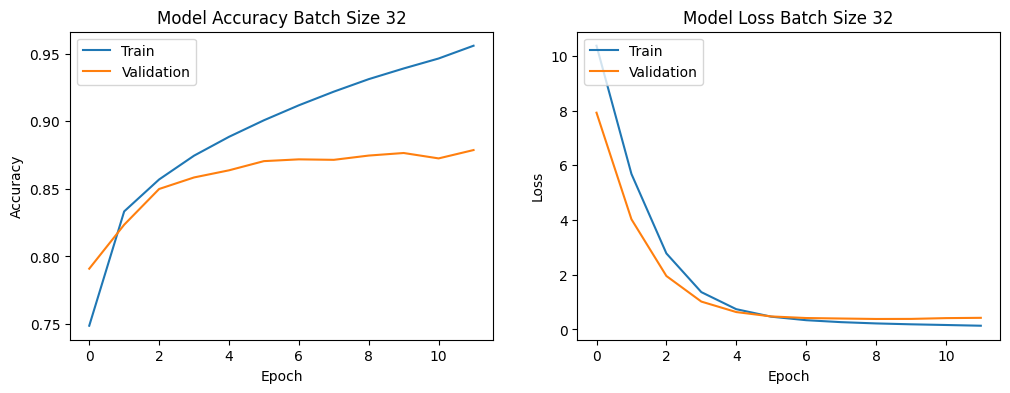

In [20]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy Batch Size 32')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss Batch Size 32')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)

In [ ]:
def plot_training_loaded_history(loaded_history):
    # Extracting the keys from the dictionary
    accuracy = loaded_history['accuracy']
    val_accuracy = loaded_history['val_accuracy']
    loss = loaded_history['loss']
    val_loss = loaded_history['val_loss']
    
    # Get the number of epochs
    epochs = range(len(accuracy))
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy)
    plt.plot(epochs, val_accuracy)
    plt.title('Model Accuracy Batch Size 16')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(np.arange(len(epochs)))  # Force x-axis to have integer ticks
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Model Loss Batch Size 16')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(np.arange(len(epochs)))  # Force x-axis to have integer ticks
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Assuming `loaded_history` is the dictionary with the training history data
plot_training_loaded_history(loaded_history)

**<h1>SAVE MODEL</h1>**

In [ ]:
#combined_model.save('./fix/cnn_classifier_model.keras')

In [ ]:
#combined_model.save_weights('./fix/bert_cnn_model_tfbertmodel_weights')

**<h1>LOAD MODEL</h1>**

In [4]:
custom_objects = {'TFBertForSequenceClassification': TFBertForSequenceClassification}
loaded_model = load_model('./fix/bert_cnn_best_model.keras', custom_objects=custom_objects)

In [ ]:
#custom_objects = {'TFBertForSequenceClassification': TFBertForSequenceClassification}
#loaded_model = load_model('./fix/bert_cnn_model_64_batch.keras', custom_objects=custom_objects, compile=False)
#optimizer = Adam(1e-6)
#loaded_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#loaded_model.load_weights('./fix/bert_cnn_model_64_batch_weights')

In [5]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 96)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 96)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 96)]         0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109484547  ['input_ids[0][0]',              
 ation_1 (TFBertForSequenceClas  rOutput(loss=None,               'token_type_ids[0][0]',     

**<h1>MINI TESTING</h1>**

In [5]:
sentiment_mapping = {
    0: 'Positive',
    1: 'Negative',
    2: 'Neutral'
}

In [6]:
def predict_sentiments(texts):
    encoded_inputs = tokenizer(texts, padding='max_length', truncation=True, max_length=shape, return_tensors='tf')
    input_ids = encoded_inputs['input_ids']
    token_type_ids = encoded_inputs['token_type_ids']
    attention_mask = encoded_inputs['attention_mask']
    
    predictions = loaded_model.predict([input_ids, token_type_ids, attention_mask])
    
    predicted_classes = np.argmax(predictions, axis=1)
    mapped_predictions = [sentiment_mapping[class_index] for class_index in predicted_classes]
    
    return mapped_predictions

In [ ]:
new_texts = ["I hate this.", "This is great!", "It's just fine."]
predictions = predict_sentiments(new_texts)
print("Predicted sentiments:", predictions)

**<h1>VALIDATION</h1>**

In [13]:
y_pred_prob = loaded_model.predict(test_tf_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

4395/4395 [==============================] - 839s 189ms/step


In [14]:
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

In [15]:
conf_matrix = confusion_matrix(y_true, y_pred)

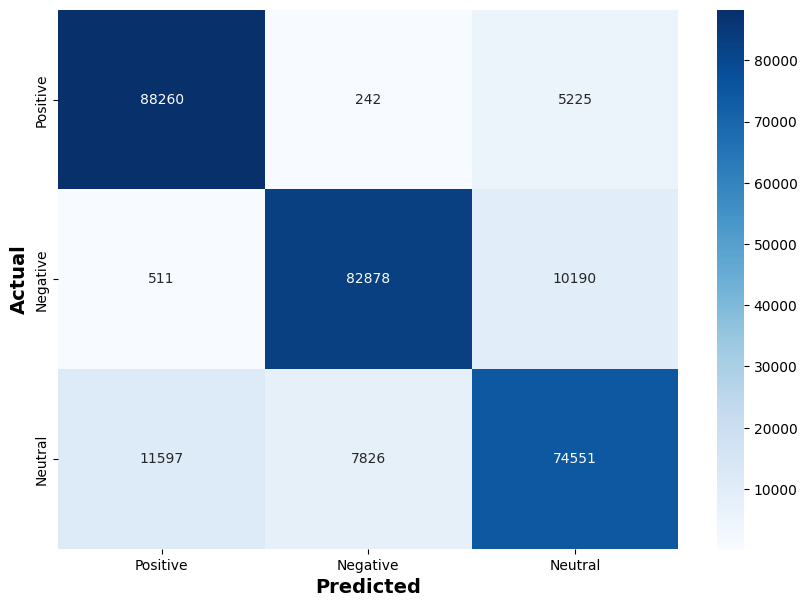

In [16]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.show()

In [17]:
print(classification_report(y_true, y_pred, target_names=['Positive', 'Negative', 'Neutral']))

              precision    recall  f1-score   support

    Positive       0.88      0.94      0.91     93727
    Negative       0.91      0.89      0.90     93579
     Neutral       0.83      0.79      0.81     93974

    accuracy                           0.87    281280
   macro avg       0.87      0.87      0.87    281280
weighted avg       0.87      0.87      0.87    281280



**<h1>BAYESIAN WEIGHTING MOVIE RECOMMENDATION**</h1>

In [7]:
new_data = pd.read_csv('./letterboxd_movie_reviews_scraped2.csv')
new_data

,Movie Title,Username,Full Review
0,What’s Up with Cinta?,yves,men should apologize for not being nicholas sa...
1,What’s Up with Cinta?,cordmer,poetic guy can do anything
2,What’s Up with Cinta?,Aditya Nathan,“What's Up with Cinta?” is a staple of Indones...
3,What’s Up with Cinta?,kiara :],before the burn book there was diary book
4,What’s Up with Cinta?,BILLY,why do you (as a man) not act like Rangga
...,...,...,...
1734,In the Absence of the Sun,Artyesha,I love it how this movie describes Jakarta cit...
1735,In the Absence of the Sun,_losingdog,hits too close to home
1736,In the Absence of the Sun,imam,I'm not even from Jakarta but Lucky Kuswandi m...
1737,In the Absence of the Sun,hfzfia,this film is both a love letter to jakarta and...


In [8]:
def clean_string(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s.]', '', text)
    sentences = text.split('.')
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return ' '.join(sentences)

In [9]:
new_data['Cleaned Review'] = new_data['Full Review'].apply(clean_string)

In [10]:
reviews_list = new_data['Cleaned Review'].tolist()
for index, value in enumerate(reviews_list):
    if isinstance(value, float):
        reviews_list[index] = str(value)

In [11]:
predictions = predict_sentiments(reviews_list)

55/55 [==============================] - 12s 114ms/step


In [12]:
new_data['Predicted Sentiment'] = predictions
new_data

,Movie Title,Username,Full Review,Cleaned Review,Predicted Sentiment
0,What’s Up with Cinta?,yves,men should apologize for not being nicholas sa...,men should apologize for not being nicholas sa...,Neutral
1,What’s Up with Cinta?,cordmer,poetic guy can do anything,poetic guy can do anything,Positive
2,What’s Up with Cinta?,Aditya Nathan,“What's Up with Cinta?” is a staple of Indones...,Whats Up with Cinta is a staple of Indonesian ...,Positive
3,What’s Up with Cinta?,kiara :],before the burn book there was diary book,before the burn book there was diary book,Neutral
4,What’s Up with Cinta?,BILLY,why do you (as a man) not act like Rangga,why do you not act like Rangga,Negative
...,...,...,...,...,...
1734,In the Absence of the Sun,Artyesha,I love it how this movie describes Jakarta cit...,I love it how this movie describes Jakarta cit...,Positive
1735,In the Absence of the Sun,_losingdog,hits too close to home,hits too close to home,Negative
1736,In the Absence of the Sun,imam,I'm not even from Jakarta but Lucky Kuswandi m...,Im not even from Jakarta but Lucky Kuswandi ma...,Neutral
1737,In the Absence of the Sun,hfzfia,this film is both a love letter to jakarta and...,this film is both a love letter to jakarta and...,Neutral


In [13]:
sentiment_counts = new_data['Predicted Sentiment'].value_counts()
sentiment_counts

Predicted Sentiment
Positive    981
Negative    456
Neutral     302
Name: count, dtype: int64

In [14]:
sentiment_counts = new_data.groupby(['Movie Title', 'Predicted Sentiment']).size().unstack(fill_value=0)

In [15]:
sentiment_counts['Total'] = (
    sentiment_counts['Positive'] + sentiment_counts['Negative'] + sentiment_counts['Neutral']
)
sentiment_counts

Predicted Sentiment,Negative,Neutral,Positive,Total
Movie Title,,,,
13 Bombs,39,16,26,81
27 Steps of May,22,17,47,86
Autobiography,27,16,38,81
Blessed You,25,12,46,83
Fiction.,19,13,54,86
Gundala,30,11,38,79
Hell Torture,65,7,9,81
In the Absence of the Sun,13,18,55,86
Kadet 1947,19,10,52,81


In [16]:
global_positive_mean = sentiment_counts['Positive'].sum() / sentiment_counts['Total'].sum()
global_negative_mean = sentiment_counts['Negative'].sum() / sentiment_counts['Total'].sum()
global_neutral_mean = sentiment_counts['Neutral'].sum() / sentiment_counts['Total'].sum()

In [17]:
total_counts = sentiment_counts['Total'].sum()
positive_ratio = sentiment_counts['Positive'].sum() / total_counts
neutral_ratio = sentiment_counts['Neutral'].sum() / total_counts
negative_ratio = sentiment_counts['Negative'].sum() / total_counts

In [18]:
weight = sentiment_counts['Total'].mean() / 2

In [19]:
def bayesian_score(row, global_positive_mean, global_neutral_mean, global_negative_mean, weights, weight=weight):
    return (
        ((row['Positive'] + global_positive_mean * weights['positive']) /
         (row['Total'] + weight)) +
        ((row['Neutral'] + global_neutral_mean * weights['neutral']) /
         (row['Total'] + weight)) +
        ((row['Negative'] + global_negative_mean * weights['negative']) /
         (row['Total'] + weight))
    )

In [20]:
def optimize_weights(sentiment_counts, global_positive_mean, global_neutral_mean, global_negative_mean):
    def objective_function(params):
        weights = {'positive': params[0], 'neutral': params[1], 'negative': params[2]}
        scores = sentiment_counts.apply(
            bayesian_score,
            axis=1,
            global_positive_mean=global_positive_mean,
            global_neutral_mean=global_neutral_mean,
            global_negative_mean=global_negative_mean,
            weights=weights,
            weight=weight
        )
        return -np.corrcoef(scores, sentiment_counts['Total'])[0, 1]

    result = minimize(objective_function, initial_weights, bounds=bounds)
    return {'positive': result.x[0], 'neutral': result.x[1], 'negative': result.x[2]}

In [21]:
initial_weights = [
    positive_ratio,
    neutral_ratio,
    -negative_ratio
]

In [22]:
bounds = [
    (0, 1),
    (0, 1),
    (-1, 0)
]

In [23]:
optimal_weights = optimize_weights(sentiment_counts, global_positive_mean, global_neutral_mean, global_negative_mean)
print("Optimal Weights:", optimal_weights)

Optimal Weights: {'positive': 0.5641173087981599, 'neutral': 0.17366302472685452, 'negative': -0.2622196664749856}


In [24]:
sentiment_counts['Score'] = sentiment_counts.apply(
    bayesian_score,
    axis=1,
    global_positive_mean=global_positive_mean,
    global_neutral_mean=global_neutral_mean,
    global_negative_mean=global_negative_mean,
    weights=optimal_weights,
    weight=weight
)

In [25]:
sorted_movies = sentiment_counts.sort_values(by='Score', ascending=False)

In [26]:
print('\nCNN+Fine-Tuned BERT Movie Recommendation (Sorted by Sentiment Score):')
for index, (movie, row) in enumerate(sorted_movies.iterrows(), start=1):
    print(f"{index}. {movie}: Bayesian Score={row['Score']}, Positive={row['Positive']}, Neutral={row['Neutral']}, Negative={row['Negative']}")


CNN+Fine-Tuned BERT Movie Recommendation (Sorted by Sentiment Score):
1. The Crescent Moon: Bayesian Score=0.6870346760811347, Positive=54.0, Neutral=23.0, Negative=13.0
2. 27 Steps of May: Bayesian Score=0.6772088165374289, Positive=47.0, Neutral=17.0, Negative=22.0
3. Sherina’s Adventure 2: Bayesian Score=0.6772088165374289, Positive=58.0, Neutral=7.0, Negative=21.0
4. Sherina’s Adventure: Bayesian Score=0.6772088165374288, Positive=55.0, Neutral=18.0, Negative=13.0
5. Fiction.: Bayesian Score=0.6772088165374288, Positive=54.0, Neutral=13.0, Negative=19.0
6. Tjoet Nja’ Dhien: Bayesian Score=0.6772088165374288, Positive=53.0, Neutral=17.0, Negative=16.0
7. The Red Point of Marriage: Bayesian Score=0.6772088165374288, Positive=63.0, Neutral=10.0, Negative=13.0
8. In the Absence of the Sun: Bayesian Score=0.6772088165374288, Positive=55.0, Neutral=18.0, Negative=13.0
9. Missing Home: Bayesian Score=0.6772088165374288, Positive=55.0, Neutral=13.0, Negative=18.0
10. Lovely Man: Bayesian 

In [27]:
movie_titles = [
    'Hell Torture', 'Lovely Man', 'Fiction.', 'Preman Pensiun', 'In the Absence of the Sun',
    "What’s Up with Cinta?", "What’s Up with Cinta 2", 'Blessed You', 'Missing Home',
    'Gundala', 'Autobiography', 'Tjoet Nja’ Dhien', 'The Crescent Moon', '13 Bombs',
    '27 Steps of May', 'Marlina the Murderer in Four Acts', "Sherina’s Adventure",
    "Sherina’s Adventure 2", 'The Red Point of Marriage', 'Puspa Indah Taman Hati', 'Kadet 1947'
]

movie_imdb_rating = [
    4.4, 7.6, 7.7, 6.5, 7.4,
    7.7, 7.3, 5.8, 8.0,
    6.1, 7.2, 7.8, 7.5, 6.6,
    7.9, 6.9, 7.8,
    7.2, 7.8, 7.7, 6.3
]

In [28]:
ndcg_count = sentiment_counts.reindex(movie_titles)
ndcg_count['IMDb Rating'] = movie_imdb_rating

In [29]:
min_rating, max_rating = ndcg_count['IMDb Rating'].min(), ndcg_count['IMDb Rating'].max()
normalized_imdb_ratings = (ndcg_count['IMDb Rating'] - min_rating) / (max_rating - min_rating)
ndcg = ndcg_score([normalized_imdb_ratings.values], [ndcg_count['Score'].values])
print('NDCG Score:', ndcg)

NDCG Score: 0.9680345528533587


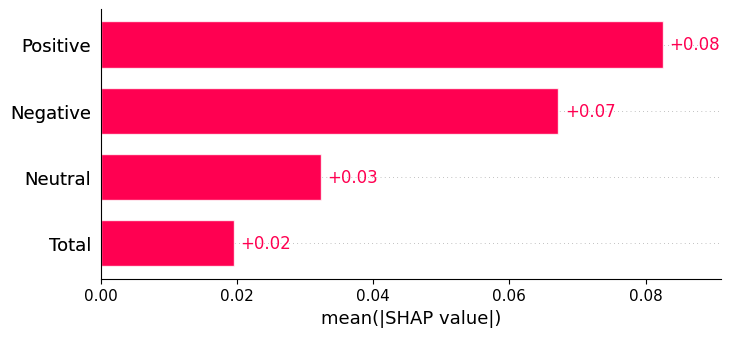

In [30]:
def bayesian_score_shap(values):
    scores = []
    for row in values:
        row_dict = {f: v for f, v in zip(feature_names, row)}
        score = (
            ((row_dict['Positive'] + global_positive_mean * optimal_weights['positive']) /
             (row_dict['Total'] + weight)) +
            ((row_dict['Neutral'] + global_neutral_mean * optimal_weights['neutral']) /
             (row_dict['Total'] + weight)) +
            ((row_dict['Negative'] + global_negative_mean * optimal_weights['negative']) /
             (row_dict['Total'] + weight))
        )
        scores.append(score)
    return np.array(scores)
    
feature_names = ['Positive', 'Neutral', 'Negative', 'Total']

shap_data = sentiment_counts[['Positive', 'Neutral', 'Negative', 'Total']].values

shap_explainer = shap.Explainer(bayesian_score_shap, shap_data)

shap_values = shap_explainer(shap_data)

shap_explanation = shap.Explanation(
    values=shap_values.values,
    base_values=shap_values.base_values,
    data=shap_data,
    feature_names=feature_names
)

shap.plots.bar(shap_explanation)

**<h1>LOGARITHMIC NORMALIZATION MOVIE RECOMMENDATION**</h1>

In [7]:
new_data = pd.read_csv('./letterboxd_movie_reviews_scraped2.csv')
new_data

,Movie Title,Username,Full Review
0,What’s Up with Cinta?,yves,men should apologize for not being nicholas sa...
1,What’s Up with Cinta?,cordmer,poetic guy can do anything
2,What’s Up with Cinta?,Aditya Nathan,“What's Up with Cinta?” is a staple of Indones...
3,What’s Up with Cinta?,kiara :],before the burn book there was diary book
4,What’s Up with Cinta?,BILLY,why do you (as a man) not act like Rangga
...,...,...,...
1734,In the Absence of the Sun,Artyesha,I love it how this movie describes Jakarta cit...
1735,In the Absence of the Sun,_losingdog,hits too close to home
1736,In the Absence of the Sun,imam,I'm not even from Jakarta but Lucky Kuswandi m...
1737,In the Absence of the Sun,hfzfia,this film is both a love letter to jakarta and...


In [8]:
def clean_string(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s.]', '', text)
    sentences = text.split('.')
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return ' '.join(sentences)

In [9]:
new_data['Cleaned Review'] = new_data['Full Review'].apply(clean_string)

In [10]:
reviews_list = new_data['Cleaned Review'].tolist()
for index, value in enumerate(reviews_list):
    if isinstance(value, float):
        reviews_list[index] = str(value)

In [11]:
predictions = predict_sentiments(reviews_list)

55/55 [==============================] - 10s 109ms/step


In [12]:
new_data['Predicted Sentiment'] = predictions
new_data

,Movie Title,Username,Full Review,Cleaned Review,Predicted Sentiment
0,What’s Up with Cinta?,yves,men should apologize for not being nicholas sa...,men should apologize for not being nicholas sa...,Neutral
1,What’s Up with Cinta?,cordmer,poetic guy can do anything,poetic guy can do anything,Positive
2,What’s Up with Cinta?,Aditya Nathan,“What's Up with Cinta?” is a staple of Indones...,Whats Up with Cinta is a staple of Indonesian ...,Positive
3,What’s Up with Cinta?,kiara :],before the burn book there was diary book,before the burn book there was diary book,Neutral
4,What’s Up with Cinta?,BILLY,why do you (as a man) not act like Rangga,why do you not act like Rangga,Negative
...,...,...,...,...,...
1734,In the Absence of the Sun,Artyesha,I love it how this movie describes Jakarta cit...,I love it how this movie describes Jakarta cit...,Positive
1735,In the Absence of the Sun,_losingdog,hits too close to home,hits too close to home,Negative
1736,In the Absence of the Sun,imam,I'm not even from Jakarta but Lucky Kuswandi m...,Im not even from Jakarta but Lucky Kuswandi ma...,Neutral
1737,In the Absence of the Sun,hfzfia,this film is both a love letter to jakarta and...,this film is both a love letter to jakarta and...,Neutral


In [13]:
sentiment_counts = new_data['Predicted Sentiment'].value_counts()
sentiment_counts

Predicted Sentiment
Positive    981
Negative    456
Neutral     302
Name: count, dtype: int64

In [14]:
sentiment_counts = new_data.groupby(['Movie Title', 'Predicted Sentiment']).size().unstack(fill_value=0)

In [15]:
sentiment_counts['Total'] = (
    sentiment_counts['Positive'] + sentiment_counts['Negative'] + sentiment_counts['Neutral']
)
sentiment_counts

Predicted Sentiment,Negative,Neutral,Positive,Total
Movie Title,,,,
13 Bombs,39,16,26,81
27 Steps of May,22,17,47,86
Autobiography,27,16,38,81
Blessed You,25,12,46,83
Fiction.,19,13,54,86
Gundala,30,11,38,79
Hell Torture,65,7,9,81
In the Absence of the Sun,13,18,55,86
Kadet 1947,19,10,52,81


In [16]:
sentiment_counts['Pos. Freq.'] = sentiment_counts['Positive'] / sentiment_counts['Total']
sentiment_counts['Neu. Freq.'] = sentiment_counts['Neutral'] / sentiment_counts['Total']
sentiment_counts['Neg. Freq.'] = sentiment_counts['Negative'] / sentiment_counts['Total']

In [17]:
positive_ratio = sentiment_counts['Positive'].sum() / sentiment_counts['Total'].sum()
neutral_ratio = sentiment_counts['Neutral'].sum() / sentiment_counts['Total'].sum()
negative_ratio = sentiment_counts['Negative'].sum() / sentiment_counts['Total'].sum()

In [18]:
def log_score(row, weights):
    return (
        np.log1p(row['Pos. Freq.']) * weights['positive'] +
        np.log1p(row['Neu. Freq.']) * weights['neutral'] +
        np.log1p(row['Neg. Freq.']) * weights['negative']
    )

In [19]:
def optimize_log_weights(sentiment_counts):
    def objective_function(params):
        weights = {'positive': params[0], 'neutral': params[1], 'negative': params[2]}
        scores = sentiment_counts.apply(log_score, axis=1, weights=weights)
        return -np.corrcoef(scores, sentiment_counts['Total'])[0, 1]

    initial_weights = [positive_ratio, neutral_ratio, -negative_ratio]
    bounds = [(0, 1), (0, 1), (-1, 0)]

    result = minimize(objective_function, initial_weights, bounds=bounds)
    return {'positive': result.x[0], 'neutral': result.x[1], 'negative': result.x[2]}

In [20]:
optimal_weights = optimize_log_weights(sentiment_counts)
print("Optimal Weights:", optimal_weights)

Optimal Weights: {'positive': 0.7491292024807663, 'neutral': 0.0, 'negative': 0.0}


In [21]:
sentiment_counts['Log. Pos.'] = np.log1p(sentiment_counts['Pos. Freq.']) * optimal_weights['positive']
sentiment_counts['Log. Neu.'] = np.log1p(sentiment_counts['Neu. Freq.']) * optimal_weights['neutral']
sentiment_counts['Log. Neg.'] = np.log1p(sentiment_counts['Neg. Freq.']) * optimal_weights['negative']

In [22]:
sentiment_counts['Score'] = sentiment_counts['Log. Pos.'] + sentiment_counts['Log. Neu.'] + sentiment_counts['Log. Neg.']

In [23]:
sorted_movies = sentiment_counts.sort_values(by='Score', ascending=False)

In [24]:
print('\nCNN+Fine-Tuned BERT Movie Recommendation (Sorted by Sentiment Score):')
for index, (movie, row) in enumerate(sorted_movies.iterrows(), start=1):
    print(f"{index}. {movie}: Log. Norm. Score={row['Score']}, Positive={row['Positive']}, Neutral={row['Neutral']}, Negative={row['Negative']}")


CNN+Fine-Tuned BERT Movie Recommendation (Sorted by Sentiment Score):
1. The Red Point of Marriage: Log. Norm. Score=0.41172066781475053, Positive=63.0, Neutral=10.0, Negative=13.0
2. Puspa Indah Taman Hati: Log. Norm. Score=0.41035899109281715, Positive=62.0, Neutral=13.0, Negative=10.0
3. Marlina the Murderer in Four Acts: Log. Norm. Score=0.39164610658614, Positive=57.0, Neutral=9.0, Negative=17.0
4. Sherina’s Adventure 2: Log. Norm. Score=0.38615063597492716, Positive=58.0, Neutral=7.0, Negative=21.0
5. Kadet 1947: Log. Norm. Score=0.37149315169523145, Positive=52.0, Neutral=10.0, Negative=19.0
6. In the Absence of the Sun: Log. Norm. Score=0.37037891233305376, Positive=55.0, Neutral=18.0, Negative=13.0
7. Missing Home: Log. Norm. Score=0.37037891233305376, Positive=55.0, Neutral=13.0, Negative=18.0
8. Sherina’s Adventure: Log. Norm. Score=0.37037891233305376, Positive=55.0, Neutral=18.0, Negative=13.0
9. Fiction.: Log. Norm. Score=0.36504700937968215, Positive=54.0, Neutral=13.0,

In [25]:
movie_titles = [
    'Hell Torture', 'Lovely Man', 'Fiction.', 'Preman Pensiun', 'In the Absence of the Sun',
    "What’s Up with Cinta?", "What’s Up with Cinta 2", 'Blessed You', 'Missing Home',
    'Gundala', 'Autobiography', 'Tjoet Nja’ Dhien', 'The Crescent Moon', '13 Bombs',
    '27 Steps of May', 'Marlina the Murderer in Four Acts', "Sherina’s Adventure",
    "Sherina’s Adventure 2", 'The Red Point of Marriage', 'Puspa Indah Taman Hati', 'Kadet 1947'
]

movie_imdb_rating = [
    4.4, 7.6, 7.7, 6.5, 7.4,
    7.7, 7.3, 5.8, 8.0,
    6.1, 7.2, 7.8, 7.5, 6.6,
    7.9, 6.9, 7.8,
    7.2, 7.8, 7.7, 6.3
]

In [26]:
ndcg_count = sentiment_counts.reindex(movie_titles)
ndcg_count['IMDb Rating'] = movie_imdb_rating

In [27]:
min_rating, max_rating = ndcg_count['IMDb Rating'].min(), ndcg_count['IMDb Rating'].max()
normalized_imdb_ratings = (ndcg_count['IMDb Rating'] - min_rating) / (max_rating - min_rating)
ndcg = ndcg_score([normalized_imdb_ratings.values], [ndcg_count['Score'].values])
print('NDCG Score:', ndcg)

NDCG Score: 0.9619464152240786


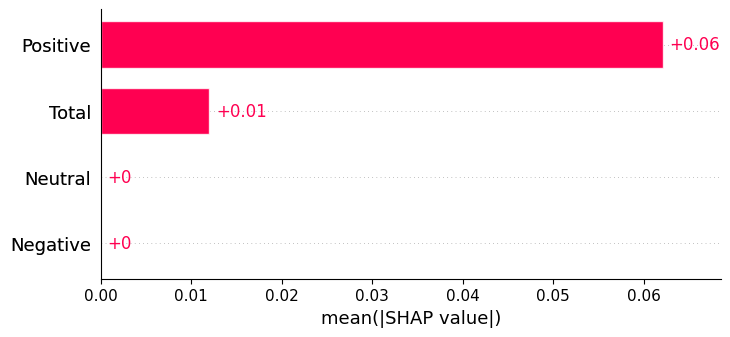

In [29]:
def shap_log_normalisation_score(data):
    results = []
    for values in data:
        row = pd.Series({f: v for f, v in zip(features, values)})
        score = (
            np.log1p(row['Positive'] / row['Total']) * optimal_weights['positive'] +
            np.log1p(row['Neutral'] / row['Total']) * optimal_weights['neutral'] +
            np.log1p(row['Negative'] / row['Total']) * optimal_weights['negative']
        )
        results.append(score)
    return np.array(results)

features = ['Positive', 'Neutral', 'Negative', 'Total']

shap_data = sentiment_counts[features].values

shap_explainer_ln = shap.Explainer(shap_log_normalisation_score, shap_data)

shap_values_ln = shap_explainer_ln(shap_data)

shap_explanation_ln = shap.Explanation(
    values=shap_values_ln.values,
    base_values=shap_values_ln.base_values,
    data=shap_data,
    feature_names=features
)

shap.plots.bar(shap_explanation_ln)

**<h1>TF-IDF WEIGHTING MOVIE RECOMMENDATION**</h1>

In [7]:
new_data = pd.read_csv('./letterboxd_movie_reviews_scraped2.csv')
new_data

,Movie Title,Username,Full Review
0,What’s Up with Cinta?,yves,men should apologize for not being nicholas sa...
1,What’s Up with Cinta?,cordmer,poetic guy can do anything
2,What’s Up with Cinta?,Aditya Nathan,“What's Up with Cinta?” is a staple of Indones...
3,What’s Up with Cinta?,kiara :],before the burn book there was diary book
4,What’s Up with Cinta?,BILLY,why do you (as a man) not act like Rangga
...,...,...,...
1734,In the Absence of the Sun,Artyesha,I love it how this movie describes Jakarta cit...
1735,In the Absence of the Sun,_losingdog,hits too close to home
1736,In the Absence of the Sun,imam,I'm not even from Jakarta but Lucky Kuswandi m...
1737,In the Absence of the Sun,hfzfia,this film is both a love letter to jakarta and...


In [8]:
def clean_string(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s.]', '', text)
    sentences = text.split('.')
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return ' '.join(sentences)

In [9]:
new_data['Cleaned Review'] = new_data['Full Review'].apply(clean_string)

In [10]:
reviews_list = new_data['Cleaned Review'].tolist()
for index, value in enumerate(reviews_list):
    if isinstance(value, float):
        reviews_list[index] = str(value)

In [11]:
predictions = predict_sentiments(reviews_list)

55/55 [==============================] - 10s 109ms/step


In [12]:
new_data['Predicted Sentiment'] = predictions

In [13]:
sentiment_counts = new_data['Predicted Sentiment'].value_counts()
sentiment_counts

Predicted Sentiment
Positive    981
Negative    456
Neutral     302
Name: count, dtype: int64

In [14]:
sentiment_counts = new_data.groupby(['Movie Title', 'Predicted Sentiment']).size().unstack(fill_value=0)

In [15]:
sentiment_counts['Total'] = (
    sentiment_counts['Positive'] + sentiment_counts['Negative'] + sentiment_counts['Neutral']
)
sentiment_counts

Predicted Sentiment,Negative,Neutral,Positive,Total
Movie Title,,,,
13 Bombs,39,16,26,81
27 Steps of May,22,17,47,86
Autobiography,27,16,38,81
Blessed You,25,12,46,83
Fiction.,19,13,54,86
Gundala,30,11,38,79
Hell Torture,65,7,9,81
In the Absence of the Sun,13,18,55,86
Kadet 1947,19,10,52,81


In [16]:
def tf_score(row, weights):
    return (
        (weights['positive'] * (row['Positive'] / row['Total'])) +
        (weights['neutral'] * (row['Neutral'] / row['Total'])) +
        (weights['negative'] * (row['Negative'] / row['Total']))
    )

In [17]:
def objective_function(params):
    weights = {'positive': params[0], 'neutral': params[1], 'negative': params[2]}
    sentiment_counts['Score'] = sentiment_counts.apply(
        tf_score, axis=1, weights=weights
    )
    return -np.corrcoef(sentiment_counts['Score'], sentiment_counts['Total'])[0, 1]

In [18]:
total_counts = sentiment_counts[['Positive', 'Neutral', 'Negative']].sum().sum()

In [19]:
positive_proportion = sentiment_counts['Positive'].sum() / total_counts
neutral_proportion = sentiment_counts['Neutral'].sum() / total_counts
negative_proportion = sentiment_counts['Negative'].sum() / total_counts

In [20]:
initial_weights = [
    positive_proportion,
    neutral_proportion,
    -negative_proportion
]

In [21]:
bounds = [(0, 1), (0, 1), (-1, 0)]

In [22]:
result = minimize(objective_function, initial_weights, bounds=bounds, method='L-BFGS-B')

In [23]:
optimal_weights = {'positive': result.x[0], 'neutral': result.x[1], 'negative': result.x[2]}
print("Optimal Weights:", optimal_weights)

Optimal Weights: {'positive': 0.7565789338092522, 'neutral': 0.0, 'negative': 0.0}


In [24]:
sentiment_counts['Score'] = sentiment_counts.apply(
    tf_score, axis=1, weights=optimal_weights
)

In [25]:
sorted_movies = sentiment_counts.sort_values(by='Score', ascending=False)

In [26]:
print('\nCNN+Fine-Tuned BERT Movie Recommendation (Sorted by Sentiment Score):')
for index, (movie, row) in enumerate(sorted_movies.iterrows(), start=1):
    print(f"{index}. {movie}: TF Score={row['Score']}, Positive={row['Positive']}, Neutral={row['Neutral']}, Negative={row['Negative']}")


CNN+Fine-Tuned BERT Movie Recommendation (Sorted by Sentiment Score):
1. The Red Point of Marriage: TF Score=0.5542380561625917, Positive=63.0, Neutral=10.0, Negative=13.0
2. Puspa Indah Taman Hati: TF Score=0.5518575752491016, Positive=62.0, Neutral=13.0, Negative=10.0
3. Marlina the Murderer in Four Acts: TF Score=0.5195783039412937, Positive=57.0, Neutral=9.0, Negative=17.0
4. Sherina’s Adventure 2: TF Score=0.5102509088481003, Positive=58.0, Neutral=7.0, Negative=21.0
5. Kadet 1947: TF Score=0.4857049945442113, Positive=52.0, Neutral=10.0, Negative=19.0
6. In the Absence of the Sun: TF Score=0.48385862045940553, Positive=55.0, Neutral=18.0, Negative=13.0
7. Missing Home: TF Score=0.48385862045940553, Positive=55.0, Neutral=13.0, Negative=18.0
8. Sherina’s Adventure: TF Score=0.48385862045940553, Positive=55.0, Neutral=18.0, Negative=13.0
9. Fiction.: TF Score=0.47506119099650723, Positive=54.0, Neutral=13.0, Negative=19.0
10. Tjoet Nja’ Dhien: TF Score=0.46626376153360893, Positiv

In [27]:
movie_titles = [
    'Hell Torture', 'Lovely Man', 'Fiction.', 'Preman Pensiun', 'In the Absence of the Sun',
    "What’s Up with Cinta?", "What’s Up with Cinta 2", 'Blessed You', 'Missing Home',
    'Gundala', 'Autobiography', 'Tjoet Nja’ Dhien', 'The Crescent Moon', '13 Bombs',
    '27 Steps of May', 'Marlina the Murderer in Four Acts', "Sherina’s Adventure",
    "Sherina’s Adventure 2", 'The Red Point of Marriage', 'Puspa Indah Taman Hati', 'Kadet 1947'
]

movie_imdb_rating = [
    4.4, 7.6, 7.7, 6.5, 7.4,
    7.7, 7.3, 5.8, 8.0,
    6.1, 7.2, 7.8, 7.5, 6.6,
    7.9, 6.9, 7.8,
    7.2, 7.8, 7.7, 6.3
]

In [28]:
ndcg_count = sentiment_counts.reindex(movie_titles)  # Align index with movie_titles
ndcg_count['IMDb Rating'] = movie_imdb_rating

In [29]:
min_rating, max_rating = ndcg_count['IMDb Rating'].min(), ndcg_count['IMDb Rating'].max()
normalized_imdb_ratings = (ndcg_count['IMDb Rating'] - min_rating) / (max_rating - min_rating)
ndcg = ndcg_score([normalized_imdb_ratings.values], [ndcg_count['Score'].values])
print('NDCG Score:', ndcg)

NDCG Score: 0.9619464152240786


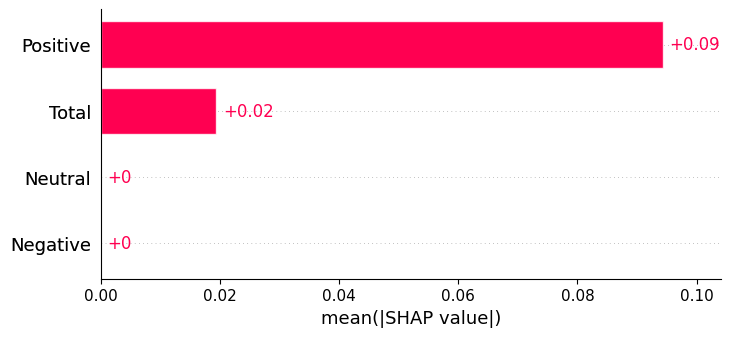

In [30]:
def shap_term_frequency_score(values):
    positive = values[:, 0]
    neutral = values[:, 1]
    negative = values[:, 2]
    total = values[:, 3]

    # Apply term frequency formula with optimal weights
    score = (
        optimal_weights['positive'] * (positive / total) +
        optimal_weights['neutral'] * (neutral / total) +
        optimal_weights['negative'] * (negative / total)
    )
    return np.array([score]).T

features = ['Positive', 'Neutral', 'Negative', 'Total']

shap_data = sentiment_counts[features].values

shap_explainer_tf = shap.Explainer(shap_term_frequency_score, shap_data)

shap_values_tf = shap_explainer_tf(shap_data)

shap_explanation_tf = shap.Explanation(
    values=shap_values_tf.values,
    base_values=shap_values_tf.base_values,
    data=shap_data,
    feature_names=features
)

shap.plots.bar(shap_explanation_tf)